보스턴 주택 가격 회귀 구현을 해보자

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

from scipy import stats
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

dataset = load_boston()
X_feature = pd.DataFrame(dataset.data,columns=dataset.feature_names)
y_label = pd.DataFrame(dataset.target)

X_train, X_test, y_train, y_test = train_test_split(X_feature.iloc[:,:-1], y_label, test_size = 0.3)

DF = X_feature
DF['PRICE'] = y_label
print('dataset size : ',DF.shape)
DF.head()

dataset size :  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
def get_linear_reg_eval(model_name, params=None, X_train=None,y_train = None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####',model_name,'####')
    for param in params :
        if model_name == 'Ridge' :
            model = Ridge(alpha=param)     
        elif model_name == 'Lasso' :
            model = Lasso(alpha=param)     
        elif model_name == 'ElasticNet' :
            model = ElasticNet(alpha=param, l1_ratio=0.7)
            
        neg_mse_scores=cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=5)     
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha: {0}/ 5 folds의 개별 RMSE 평균 : {1}'.format(param,np.round(avg_rmse,2)))
        model.fit(X_train,y_train)
        if return_coeff:
            coeff = pd.Series(data=model.coef_,index=X_train.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname]=coeff

    return coeff_df

# [실습] LinearRegression
- RM이 양의 값으로 회귀계수가 가장 크며, NOX는 음의 값으로 회귀계수가 가장 작다.
- MSE : 29.9743 / RMSE : 5.4749 / R^2 : 0.6351
## price와 나머지 변수간의 관계를 확인 해보자.
- RM , LSTAT 변수와 price 간의 관련성이 큰편이다.

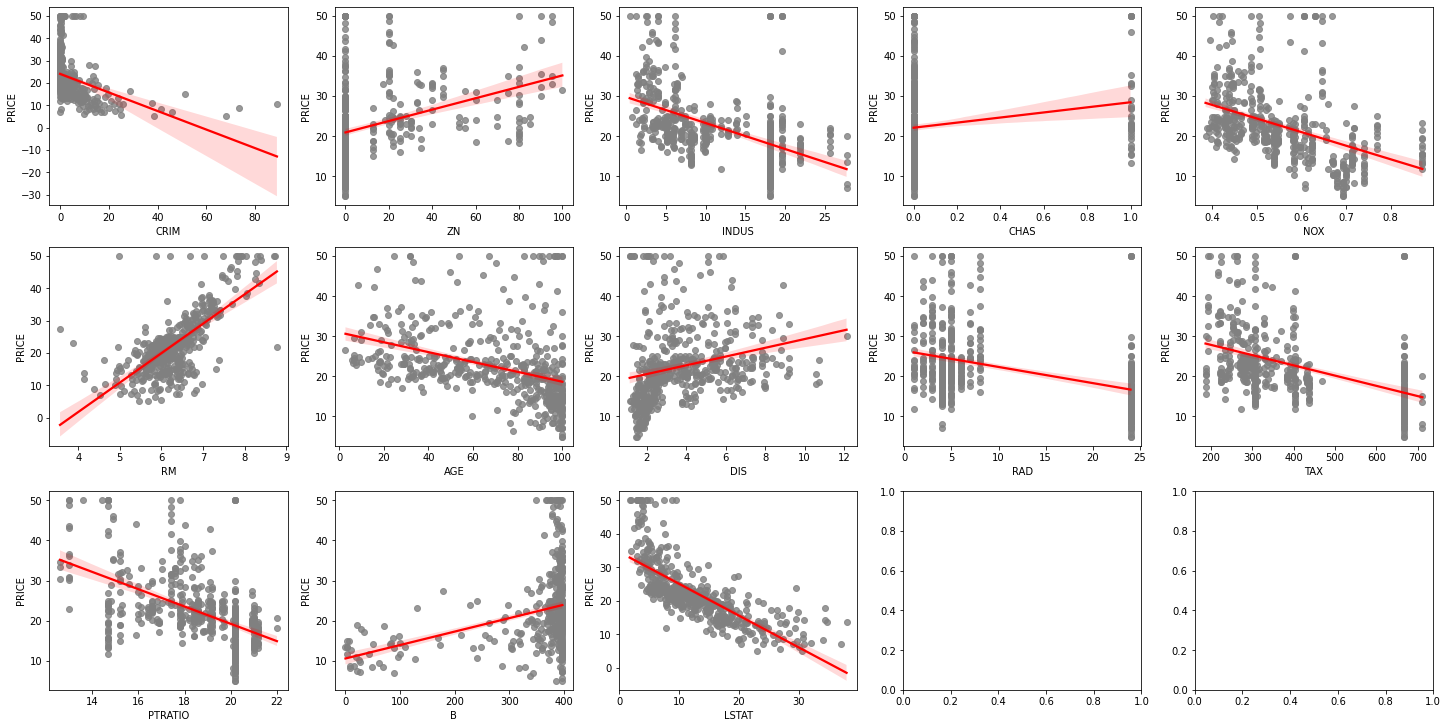

In [ ]:
fig, axs = plt.subplots(figsize = (20,10), ncols=5, nrows=3,constrained_layout = True)
lm_features = DF.iloc[:,:-1]
for i, feature in enumerate(lm_features):
    row = int(i/5)
    col = i%5
    sns.regplot(x=feature, y='PRICE', data=DF, ax=axs[row][col],line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_feature.iloc[:,:-1], y_label, test_size = 0.3)

#학습 / 예측
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred =lr.predict(X_test)

mse = mean_squared_error(y_test,lr_pred)
print('MSE : {0:.4f} / RMSE : {1:.4f} / R^2 : {2:.4f}'.format(mse,np.sqrt(mse),r2_score(y_test,lr_pred)))
print('절편값 : ',np.round(lr.intercept_,1))
print('회귀계수값 : ',np.round(lr.coef_,1))

# cross_val_score으로 5폴드 세트로 MSE를 구한 뒤 이를 기반으로 RMSE를 구함
neg_mse_scores = cross_val_score(lr, X_train,y_train,scoring='neg_mean_squared_error', cv=5)
rmse_score = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.average(rmse_score)

# cross_val_score(scoring='neg_maen_squared_error')으로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores :',np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores :',np.round(rmse_score,2))
print('5 folds의 개별 RMSE 평균 :',avg_rmse)


MSE : 29.9743 / RMSE : 5.4749 / R^2 : 0.6351
절편값 :  [41.2]
회귀계수값 :  [[ -0.1   0.1  -0.   -0.9 -16.    3.5   0.   -1.6   0.3  -0.   -1.1   0.
   -0.6]]
5 folds의 개별 Negative MSE scores : [-35.76 -18.27 -16.51 -16.32 -22.77]
5 folds의 개별 RMSE scores : [5.98 4.27 4.06 4.04 4.77]
5 folds의 개별 RMSE 평균 : 4.626035915601238


In [ ]:
coeff = pd.Series(data= np.round(lr.coef_,1)[0],index = X_train.columns)
coeff.sort_values(ascending=False)

RM          3.5
RAD         0.3
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS      -0.0
CRIM       -0.1
LSTAT      -0.6
CHAS       -0.9
PTRATIO    -1.1
DIS        -1.6
NOX       -16.0
dtype: float64

# [실습] Ridge L2
- linear regression 보다 RMSE가 낮게 나타나 예측성능이 더 나음
- RMSE : 5.15
- alpha를 증가시킬수록 회귀계수 값이 줄어듦을 확인 할 수 있다.(0이 되진 않는다.)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha = 10으로 지정해보자
ridge = Ridge(alpha=10)
neg_mse_scores =cross_val_score(ridge, X_train, y_train, scoring='neg_mean_squared_error',cv=5)
rmse= np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse)

print('5 folds의 개별 Negative MSE scores :',np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores :',np.round(rmse,2))
print('5 folds의 개별 RMSE 평균 :',np.round(avg_rmse,2))


5 folds의 개별 Negative MSE scores : [-20.23 -52.67 -21.47 -34.2  -36.39]
5 folds의 개별 RMSE scores : [4.5  7.26 4.63 5.85 6.03]
5 folds의 개별 RMSE 평균 : 5.65


In [ ]:
# 릿지에 사용될 alpha파라미터의 값을 정의
alphas=[0,0.01,1,10,100]

for alpha in alphas :
    ridge =Ridge(alpha=alpha)
    neg_mse_scores = cross_val_score(ridge,X_train,y_train, scoring='neg_mean_squared_error',cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha: {0}/ 5 folds의 개별 RMSE 평균 : {1}'.format(alpha,np.round(avg_rmse,2)))


alpha: 0/ 5 folds의 개별 RMSE 평균 : 5.59
alpha: 0.01/ 5 folds의 개별 RMSE 평균 : 5.58
alpha: 1/ 5 folds의 개별 RMSE 평균 : 5.59
alpha: 10/ 5 folds의 개별 RMSE 평균 : 5.65
alpha: 100/ 5 folds의 개별 RMSE 평균 : 6.0


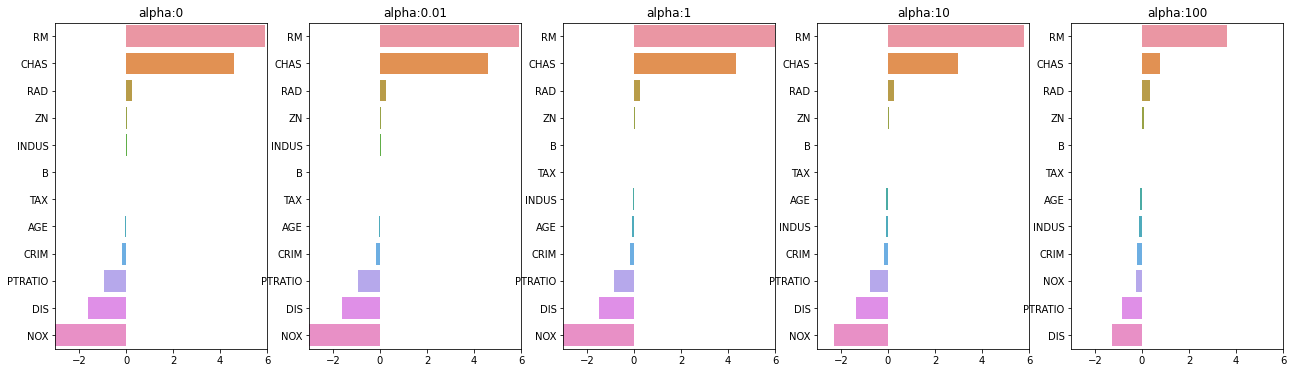

In [ ]:
fig,axs = plt.subplots(figsize=(22,6),nrows=1, ncols=5)
coeff_df = pd.DataFrame()
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    coeff = pd.Series(ridge.coef_[0], index=X_train.columns)
    colname = 'alpha:'+ str(alpha)
    coeff_df[colname] = coeff

    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index,ax=axs[pos])


In [ ]:
# alpha에 따른 회귀계수 table
coeff_df.sort_values(by='alpha:'+str(alphas[0]),ascending=False)

,alpha:0,alpha:0.01,alpha:1,alpha:10,alpha:100
RM,5.924513,5.927098,6.039582,5.805023,3.600595
CHAS,4.606782,4.603466,4.331819,2.971413,0.777115
RAD,0.274156,0.273563,0.244745,0.241076,0.321354
ZN,0.051975,0.051988,0.052738,0.055233,0.067252
INDUS,0.023764,0.022688,-0.032638,-0.084319,-0.130022
B,0.007532,0.007542,0.008084,0.009089,0.010984
TAX,-0.011045,-0.011055,-0.011622,-0.013022,-0.016453
AGE,-0.055354,-0.055561,-0.066113,-0.073939,-0.067308
CRIM,-0.180213,-0.180158,-0.177827,-0.182018,-0.206035
PTRATIO,-0.949929,-0.947736,-0.837514,-0.772219,-0.868466


# [실습] Lasso L1
- alpha: 0.1/ 5 folds의 개별 RMSE 평균 : 5.68


In [ ]:
lasso_params=[0.07,0.1,0.5,1.3]
coeff_lass_df = get_linear_reg_eval('Lasso',params=lasso_params, X_train=X_train,y_train=y_train)
coeff_lass_df.sort_values(by='alpha:0.07',ascending=False)

#### Lasso ####
alpha: 0.07/ 5 folds의 개별 RMSE 평균 : 5.69
alpha: 0.1/ 5 folds의 개별 RMSE 평균 : 5.68
alpha: 0.5/ 5 folds의 개별 RMSE 평균 : 5.79
alpha: 1.3/ 5 folds의 개별 RMSE 평균 : 6.19


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1.3
RM,6.122419,6.067429,5.229507,3.438226
CHAS,3.214268,2.658486,0.000000,0.000000
RAD,0.218006,0.223557,0.248583,0.243480
ZN,0.052936,0.052845,0.053445,0.056682
B,0.008947,0.009143,0.010333,0.011121
NOX,-0.007658,-0.000000,-0.000000,-0.000000
TAX,-0.012644,-0.012954,-0.014839,-0.016102
AGE,-0.075761,-0.074643,-0.063786,-0.046718
INDUS,-0.084170,-0.079858,-0.050191,-0.022496
CRIM,-0.175613,-0.176701,-0.178430,-0.167545


# [실습] ElasticNet
- alpha: 0.07/ 5 folds의 개별 RMSE 평균 : 5.67


In [ ]:
elastic_alpha=[0.07,0.1,0.5,1.3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet',params=elastic_alpha, X_train=X_train,y_train=y_train)
coeff_elastic_df.sort_values(by='alpha:0.07',ascending=False)

#### ElasticNet ####
alpha: 0.07/ 5 folds의 개별 RMSE 평균 : 5.67
alpha: 0.1/ 5 folds의 개별 RMSE 평균 : 5.69
alpha: 0.5/ 5 folds의 개별 RMSE 평균 : 5.93
alpha: 1.3/ 5 folds의 개별 RMSE 평균 : 6.39


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1.3
RM,5.835334,5.681448,3.959759,2.117378
CHAS,2.604805,2.083580,0.000000,0.000000
RAD,0.237043,0.243428,0.294804,0.302032
ZN,0.054677,0.055430,0.062671,0.068505
B,0.009244,0.009523,0.011000,0.011812
TAX,-0.013205,-0.013648,-0.016217,-0.017639
AGE,-0.074178,-0.073918,-0.063437,-0.048791
INDUS,-0.084822,-0.088709,-0.093325,-0.085594
CRIM,-0.180883,-0.182900,-0.194445,-0.190371
PTRATIO,-0.754428,-0.757270,-0.811958,-0.763890


# [실습] Regression Tree
- DecisionRegressor, GradientBoostingRegressor, XGB|LGBM Regressor
- RandomForestRegressor RMSE 평균 : 4.7
- DecisionTreeRegressor RMSE 평균 : 5.69
- GradientBoostingRegressor RMSE 평균 : 4.47
- XGBRegressor RMSE 평균 : 4.39
- LGBMRegressor RMSE 평균 : 4.55


In [9]:
def get_model_cv_prediction(model, X_train, y_train):
    neg_mse_scores = cross_val_score(model, X_train,y_train,scoring='neg_mean_squared_error',cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print(model.__class__.__name__)
    print('5 folds의 개별 Negative MSE scores :',np.round(neg_mse_scores,2))
    print('5 folds의 개별 RMSE 평균 :',np.round(avg_rmse,2))
    print('='*50)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_model = RandomForestRegressor(random_state=0,n_estimators=1000)
dt_model = DecisionTreeRegressor(random_state=0,max_depth=4)
gbm_model = GradientBoostingRegressor(random_state=0,n_estimators=1000)
xgb_model = XGBRegressor(objective='reg:squarederror',random_state=0,n_estimators=1000)
lgbm_model = LGBMRegressor(random_state=0,n_estimators=1000)

get_model_cv_prediction(rf_model, X_train, y_train)
get_model_cv_prediction(dt_model, X_train, y_train)
get_model_cv_prediction(gbm_model, X_train, y_train)
get_model_cv_prediction(xgb_model, X_train, y_train)
get_model_cv_prediction(lgbm_model, X_train, y_train)


RandomForestRegressor
5 folds의 개별 Negative MSE scores : [-14.43 -18.61 -19.97 -19.28 -42.29]
5 folds의 개별 RMSE 평균 : 4.7
DecisionTreeRegressor
5 folds의 개별 Negative MSE scores : [-18.35 -27.74 -25.74 -25.86 -76.27]
5 folds의 개별 RMSE 평균 : 5.69
GradientBoostingRegressor
5 folds의 개별 Negative MSE scores : [ -9.45 -18.04 -16.74 -16.61 -46.89]
5 folds의 개별 RMSE 평균 : 4.47
XGBRegressor
5 folds의 개별 Negative MSE scores : [-10.91 -16.78 -19.74 -14.52 -39.7 ]
5 folds의 개별 RMSE 평균 : 4.39
LGBMRegressor
5 folds의 개별 Negative MSE scores : [-12.99 -23.63 -16.78 -14.88 -39.95]
5 folds의 개별 RMSE 평균 : 4.55


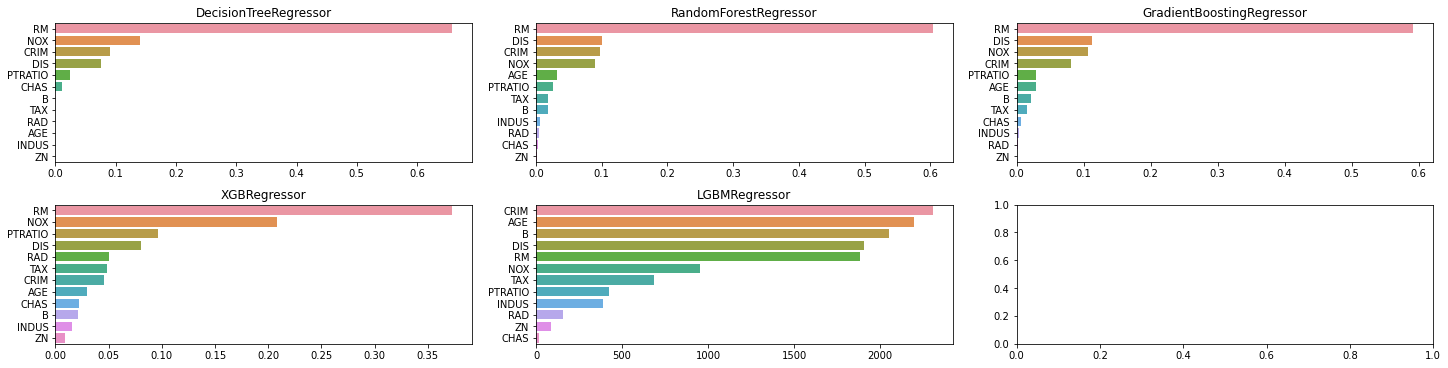

In [44]:
models = [dt_model, rf_model,gbm_model, xgb_model, lgbm_model ]
fig, axs = plt.subplots(figsize=(20,5),ncols=3,nrows=2,constrained_layout=True)
for i, model in enumerate(models):
    row = int(i/3)
    col = i%3
    model.fit(X_train,y_train)
    feature_series = pd.Series(data= model.feature_importances_, index=X_train.columns)
    feature_series = feature_series.sort_values(ascending=False)
    # print(row,col)
    sns.barplot(x= feature_series, y=feature_series.index,ax=axs[row][col])
    axs[row][col].set_title(model.__class__.__name__)


회귀트리가 어떻게 예측값을 판단하는지 시각화 해보자

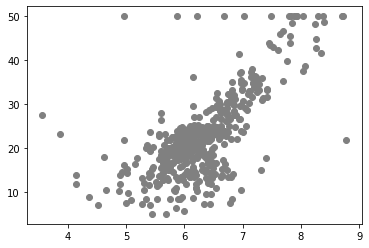

In [47]:
boston_DF = DF[['RM','PRICE']]
plt.scatter(x=boston_DF.RM, y=boston_DF.PRICE,color = 'grey')

In [95]:
# 모델 생성 
lr_reg = LinearRegression()
dt_reg_4 = DecisionTreeRegressor(max_depth=4,random_state=0)
dt_reg_8 = DecisionTreeRegressor(max_depth=8,random_state=0)

# 학습 / 예측
X_feature = boston_DF[['RM']].values.reshape(-1,1)
y_label = boston_DF[['PRICE']].values.reshape(-1,1)

lr_reg.fit(X_feature,y_label)
dt_reg_4.fit(X_feature,y_label)
dt_reg_8.fit(X_feature,y_label)

X_test = np.arange(4.5,8.5,0.04).reshape(-1,1)
lr_pred= lr_reg.predict(X_test)
dt_reg_4_pred= dt_reg_4.predict(X_test)
dt_reg_8_pred= dt_reg_8.predict(X_test)

Text(0.5, 1.0, 'DecisionTreeRegressor\n max_depth: 8')

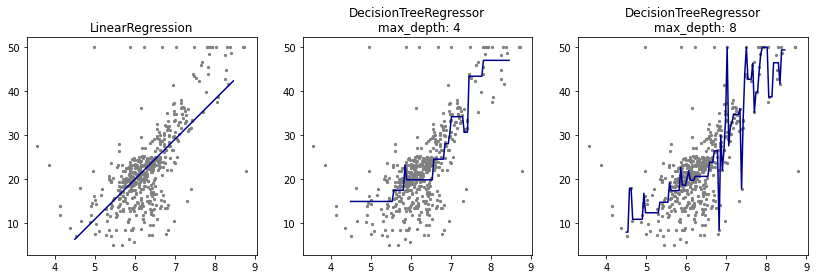

In [96]:
# Single Row of Subplots
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4),ncols=3)
ax1.scatter(X_feature,y_label,color='grey',s=5)
ax1.plot(X_test,lr_pred,color='darkblue')
ax1.set_title(lr_reg.__class__.__name__)

ax2.scatter(X_feature,y_label,color='grey',s=5)
ax2.plot(X_test,dt_reg_4_pred,color='darkblue')
ax2.set_title(dt_reg_4.__class__.__name__ +'\n max_depth: ' +str(dt_reg_4.max_depth) )

ax3.scatter(X_feature,y_label,color='grey',s=5)
ax3.plot(X_test,dt_reg_8_pred,color='darkblue')
ax3.set_title(dt_reg_8.__class__.__name__ +'\n max_depth: ' +str(dt_reg_8.max_depth) )

15